# Module Import

In [192]:
# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# STANDARD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

#PRINCIPAL COMPONENT ANALYSIS
from sklearn.decomposition import PCA

#AUTOENCODER
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# K-MEANS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# GAUSSIAN MIXTURE MODELS
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from itertools import combinations

%matplotlib inline

In [193]:
!dir

all_bops.csv  sample_data


# Training Data Preperation

In [194]:
bops_df = pd.read_csv("all_bops.csv", header = None)
display(bops_df)

,0,1,2,3,4,5,6,7,8,9,...,16454,16455,16456,16457,16458,16459,16460,16461,16462,16463
0,0.015088,0.011441,0.008684,0.007015,0.008775,0.014358,0.013308,0.012628,0.006228,0.011652,...,0.016400,0.013701,0.017407,0.021171,0.010898,0.025144,0.023711,0.014660,0.007447,0.013771
1,0.021575,0.027810,0.008036,0.015563,0.008609,0.008682,0.017500,0.022203,0.019503,0.014754,...,0.025229,0.035571,0.021757,0.024392,0.016024,0.008709,0.018759,0.026881,0.025961,0.021973
2,0.009389,0.010701,0.012135,0.015390,0.011229,0.012074,0.007491,0.013424,0.008186,0.015074,...,0.026394,0.024790,0.031689,0.022609,0.029487,0.025731,0.017381,0.031142,0.030801,0.022057
3,0.114729,0.107343,0.129847,0.113619,0.131508,0.103052,0.141064,0.103720,0.133362,0.114975,...,0.045634,0.037989,0.056437,0.032438,0.045636,0.050939,0.016501,0.038410,0.031849,0.040476
4,0.024568,0.023084,0.027421,0.040279,0.036652,0.022014,0.032264,0.029450,0.026532,0.046966,...,0.030515,0.032941,0.046456,0.046175,0.038117,0.039326,0.046104,0.054673,0.060698,0.073273
5,0.455856,0.456801,0.488366,0.443380,0.473870,0.429091,0.470595,0.417990,0.451499,0.427073,...,0.125639,0.125661,0.101816,0.073295,0.104288,0.137439,0.146561,0.118130,0.128448,0.153729
6,0.043108,0.040072,0.047649,0.066360,0.056860,0.029161,0.039187,0.051655,0.040765,0.075338,...,0.060469,0.079617,0.065851,0.049162,0.055404,0.069250,0.066255,0.056600,0.040579,0.072979
7,0.356313,0.362384,0.365040,0.339593,0.350782,0.334191,0.336000,0.322800,0.324506,0.325464,...,0.149945,0.130404,0.158184,0.139799,0.138636,0.136563,0.114444,0.121153,0.114844,0.123425


In [195]:
bops_np = np.array(bops_df.values).transpose()
print(bops_np)

[[0.01508836 0.02157479 0.00938931 ... 0.45585643 0.04310833 0.35631271]
 [0.01144127 0.02780971 0.01070126 ... 0.45680071 0.04007158 0.36238399]
 [0.00868422 0.00803573 0.01213486 ... 0.48836611 0.04764863 0.36503994]
 ...
 [0.01465988 0.02688148 0.03114179 ... 0.11813028 0.05659993 0.12115321]
 [0.00744722 0.02596095 0.03080066 ... 0.12844784 0.04057877 0.11484423]
 [0.01377141 0.02197251 0.02205674 ... 0.153729   0.072979   0.12342536]]


# Dimensionality Reduction: Autoencoder

First step is to convert our input and output data to pytorch tensors. In our case, both the input and the output is the same.

In [196]:
bops_np = bops_np.astype(np.float32)  # Convert data type to float32
X_tensor = torch.from_numpy(bops_np)
y_tensor = torch.from_numpy(bops_np)
print(f"Shape of X tensor: {X_tensor.shape}.")
print(f"Shape of y tensor: {y_tensor.shape}.")

Shape of X tensor: torch.Size([16464, 8]).
Shape of y tensor: torch.Size([16464, 8]).


We can use these PyTorch Tensor to instantiate first a TensorDataset and, in a second step, a DataLoader that includes information about batch_size.

In [197]:
#CREATE DATASET
dataset = utils.TensorDataset(X_tensor,y_tensor)

#CREATE DATA LOADER
batch_size = 100
dataloader = utils.DataLoader(dataset,
                              batch_size = batch_size,
                              shuffle=True)

PyTorch defines a NN architecture using the Net() class. The central element is the forward function. autograd automatically defines the corresponding backward function that computes the gradients.

Any legal Tensor operation is fair game for the forward function, providing a log of design flexibility. In our simple case, we just link the Tensor through functional input-output relations after initializing their attributes.

In [198]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, code_size):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, code_size),
            nn.Tanh()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(code_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, input_size),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

Here we are going to define an instance of our autoencoder, determine the loss function as well as the optimiser. Here we are using the mean square error (MSE) loss function and Stochastic Gradient Descent (SGD) optimiser with L2 regularisation and momentum. The parameters we have to define in the optimiser, are the learning rate, the weightdecay rate for the L2 regularisation, as well as the momentum.

In [199]:
# Create an instance of the Autoencoder
autoencoder = Autoencoder(input_size=8, hidden_size=80, code_size=2)
#DETERMINE LOSS FUNCTION
loss_fn= nn.MSELoss()
# Create an optimizer
optimizer = optim.SGD(autoencoder.parameters(), lr=0.001,
                       weight_decay = 1e-5, momentum = 0.5)

### Dimension of code/bottleneck

Now that we have seen how to train an autoencoder, I want to determine what is the size of the bottleneck. For that purpose we are going to train autoencoders for bottleneck sizes smaller than the input size and calculate fraction of variance explained (FVE)
$$
FVE = 1-\frac{\sum_{q=1}^Q(z_q-\hat z_q)^2}{\sum_{q=1}^Q(z_q-\bar z_q)^2}
$$
with $\bar z$ being the average of the input vector, and look for an elbow(knee).

In [200]:
fves = []
# Calculate the average input vector
mean_input = X_tensor.mean(axis=0)

for code_dimension in range(1,8):
  print("Code dimension:", code_dimension)
  # Define autoencoder, loss function and optimiser
  autoencoder = Autoencoder(input_size=8, hidden_size=80, code_size=code_dimension)
  loss_fn= nn.MSELoss()
  optimizer = optim.SGD(autoencoder.parameters(), lr=0.001,
                       weight_decay = 1e-5, momentum = 0.5)

  # Train the network
  num_epochs = 300
  for epoch in range(num_epochs):
      for batch in dataloader:
          # Get input data and target data
          input_data, target_data = batch

          # Convert the input data to float32
          input_data = input_data.float()

          # Forward pass
          encoded, output_data = autoencoder(input_data)

          # Compute the loss
          loss = loss_fn(output_data, input_data)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # Print progress
      if (epoch+1) % 100 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

  # Calculate the loss function
  _, decoded = autoencoder(X_tensor)
  loss = loss_fn(X_tensor, decoded)

  # Calculate the difference from mean vector squared
  # mean_diff = torch.sum(torch.pow(X_tensor - mean_input, 2))
  # fves.append((1 - loss/mean_diff).detach().numpy())
  fves.append(loss.detach().numpy())

Code dimension: 1
Epoch [100/300], Loss: 0.002072719857096672
Epoch [200/300], Loss: 0.0009166820673272014
Epoch [300/300], Loss: 0.0001377661246806383
Code dimension: 2
Epoch [100/300], Loss: 0.002536851679906249
Epoch [200/300], Loss: 0.001116935396566987
Epoch [300/300], Loss: 0.0004152056062594056
Code dimension: 3
Epoch [100/300], Loss: 0.0023077509831637144
Epoch [200/300], Loss: 0.001720258267596364
Epoch [300/300], Loss: 0.0004546997952274978
Code dimension: 4
Epoch [100/300], Loss: 0.0025387220084667206
Epoch [200/300], Loss: 0.002248563803732395
Epoch [300/300], Loss: 0.0010375630808994174
Code dimension: 5
Epoch [100/300], Loss: 0.0018374052597209811
Epoch [200/300], Loss: 0.0006878854474052787
Epoch [300/300], Loss: 0.00016822468023747206
Code dimension: 6
Epoch [100/300], Loss: 0.0021951687522232533
Epoch [200/300], Loss: 0.0015286384150385857
Epoch [300/300], Loss: 0.0008406726992689073
Code dimension: 7
Epoch [100/300], Loss: 0.002788456156849861
Epoch [200/300], Loss: 0

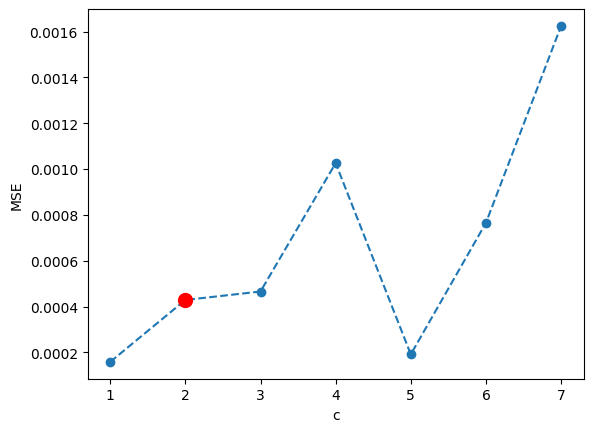

In [201]:
for i in range(len(fves)):
  fves[i] = fves[i]#.detach().numpy()
plt.plot(list(range(1,8)), fves, marker = 'o', linestyle = '--')
plt.plot(2,fves[1], marker='o', markersize=10, color='red')
plt.xlabel('c')
plt.ylabel('MSE')
plt.show()

Epoch [100/300], Loss: 0.0027
Epoch [200/300], Loss: 0.0013
Epoch [300/300], Loss: 0.0003


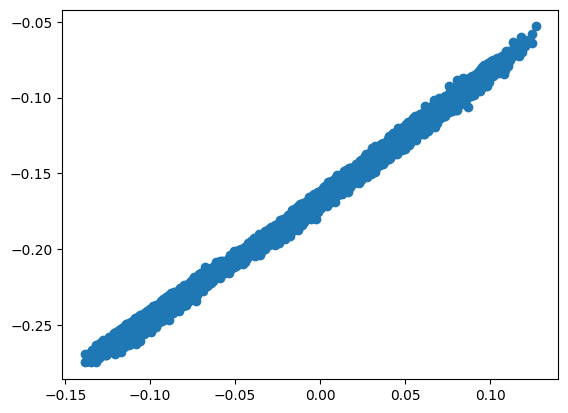

In [213]:
# Create an instance of the Autoencoder
autoencoder = Autoencoder(input_size=8, hidden_size=80, code_size=2)
#DETERMINE LOSS FUNCTION
loss_fn= nn.MSELoss()
# Create an optimizer
optimizer = optim.SGD(autoencoder.parameters(), lr=0.001,
                       weight_decay = 1e-5, momentum = 0.5)
num_epochs = 300
for epoch in range(num_epochs):
    for batch in dataloader:
        input_data, target_data = batch
        input_data = input_data.float()
        encoded, output_data = autoencoder(input_data)
        loss = loss_fn(output_data, input_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

code, decoded = autoencoder(X_tensor)
code_np = code.detach().numpy()
plt.scatter(x = code_np[:,0], y = code_np[:,1])
plt.show()

### Contribution Analysis

#### Input Perturbation

The input perturbation method assesses the vatiation in the MSE of the autoencoder by adding a small amount of white noise to the k-th input, while holding all the other inputs at their observed values. Here, we set the white noise to 10% and 50% of each input. The input variables whose changes affect the output the most, leading to a large increase in the MSE, are the ones that have the most relative influence.

First, we start by passing the full original dataset into the autoencoder and calculate the loss function, which will serve as a benchmark for the contribution analysis.

In [214]:
input_data = X_tensor
code, decoded = autoencoder(input_data)
loss_og = loss_fn(decoded, input_data).item()
print("Original loss function: ", loss_og)

Original loss function:  0.0003427420451771468


Now, we are going to add a perturbation of 30% of the original input, for each input, while keeping the rest fixed at their original values.

In [215]:
relative_importances = {}
means = torch.mean(input_data, axis = 0).tolist()

for delta in [0.1, 0.5, -1]:
  num_input_nodes = input_data.shape[1]
  losses = []

  for i in range(num_input_nodes):

    # Clone the input data and perturb the node i.
    perturbed_data = input_data.clone()
    perturbed_data[:,i] *= (1 + delta)
    if delta < 0:
      perturbed_data[:,i] = means[i]

    # Calculate the loss function
    _, decoded_pert = autoencoder(perturbed_data)
    loss_pert = loss_fn(decoded_pert, perturbed_data).detach().item()

    # Keep all losses
    losses.append(loss_pert)

  # Sort the nodes that lead to higher cost functions from perturbation
  losses = np.array(losses)
  input_nodes = np.arange(num_input_nodes)
  losses = np.vstack([input_nodes, losses])
  losses = losses[:, np.argsort(losses[1])[::-1]]

  # Calculate relative importance
  d_losses = losses[1] - loss_og
  relative_importance = d_losses / np.sum(d_losses)

  relative_importances[delta] = [relative_importance, losses[0]]

  print("- The nodes that lead to higher cost function:", losses[0])
  print("- Cost function:", losses[1])
  print("- Change in loss relative to original:", d_losses)
  print("- Relative importance:", relative_importance)

- The nodes that lead to higher cost function: [7. 5. 3. 6. 1. 4. 0. 2.]
- Cost function: [0.00045522 0.0004175  0.00036674 0.00035966 0.00034607 0.00034562
 0.0003444  0.00034329]
- Change in loss relative to original: [1.12473528e-04 7.47586018e-05 2.39963992e-05 1.69183768e-05
 3.32537456e-06 2.87557486e-06 1.65979145e-06 5.46366209e-07]
- Relative importance: [0.47546658 0.31603185 0.10144152 0.07152014 0.01405757 0.0121561
 0.00701654 0.00230969]
- The nodes that lead to higher cost function: [7. 5. 3. 6. 4. 1. 0. 2.]
- Cost function: [0.00221621 0.00196557 0.00065867 0.00055792 0.00039869 0.00037336
 0.0003592  0.00035322]
- Change in loss relative to original: [1.87347041e-03 1.62282799e-03 3.15923273e-04 2.15175707e-04
 5.59436157e-05 3.06150760e-05 1.64615631e-05 1.04779028e-05]
- Relative importance: [0.45243122 0.39190266 0.07629347 0.05196357 0.01351003 0.00739335
 0.00397536 0.00253035]
- The nodes that lead to higher cost function: [5. 7. 3. 4. 2. 0. 1. 6.]
- Cost functio

####Improved Stepwise Function

In [216]:
num_input_nodes = input_data.shape[1] # Number of input nodes
num_data_points = input_data.shape[0] # Nummber of data points in the dataset

input_nodes = np.arange(num_input_nodes) # All input nodes ids
remaining_nodes = list(range(num_input_nodes)) # Remaining input nodes ids
important_nodes = [] # Input nodes ids by importance

# Calculate the mean values of each input in the whole dataset
means = torch.mean(input_data, axis = 0).tolist()

input_data_copy = input_data.clone() # Copy input data

losses_ = [loss_og]
for j in range(num_input_nodes):
  losses = []
  for i in remaining_nodes:

      # Clone the input data and replace node i with the mean of the
      # column in the whole dataset.
      perturbed_data = input_data_copy.clone()
      perturbed_data[:,i] = torch.full((1, num_data_points), means[i])

      # Get the code and output of the autoencoder
      _, decoded = autoencoder(perturbed_data)

      # Calculate cost function
      loss = loss_fn(decoded, input_data).detach().item()
      losses.append(loss)

  #
  losses = np.vstack([remaining_nodes, losses])
  losses = losses[:, np.argsort(losses[1])[::-1]]
  losses_.append(np.max(losses[1]))

  idx = losses[0][0].astype(int)
  important_nodes.append(idx)
  remaining_nodes.remove(idx)

  input_data_copy[:, idx] = torch.full((1, num_data_points), means[idx])

  if j == 0:
    important_nodes_1 = losses[0].astype(int).tolist()

  # print("Tensor: ", input_data_copy)
  # print("The nodes that lead to higher cost function:", losses[0])
  # print("with corresponding values of the cost function:", losses[1])

print("Important nodes from a single removal:", important_nodes_1)
print("Important nodes from sequencial removals:", important_nodes)

Important nodes from a single removal: [5, 7, 4, 2, 1, 0, 3, 6]
Important nodes from sequencial removals: [5, 7, 4, 2, 1, 0, 3, 6]


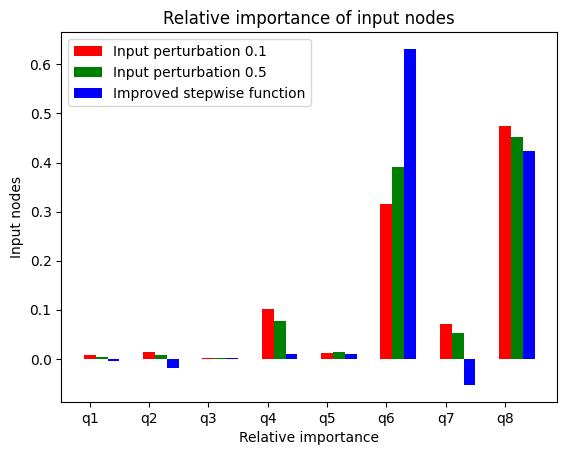

In [217]:
# Assuming you have quantities as a list of lists
sorted_arrs = []
for val in relative_importances.values():
  arr = np.vstack(val)
  sorted_arr = arr[:, np.argsort(arr[1])]
  sorted_arr = sorted_arr[0,:]
  sorted_arrs.append(sorted_arr)

sorted_arrs
quantities = np.vstack(sorted_arrs).transpose().tolist()

# Generate x-axis labels for each quantity
x_labels = [f'q{i+1}' for i in range(len(quantities))]

# Generate the positions for the bars
x_positions = np.arange(len(quantities))

# Define the width of each bar
bar_width = 0.2

# Generate the positions for the three bars within each group
bar_positions = [x_positions + i*bar_width for i in range(3)]

# Generate the colors for the bars
colors = ['red', 'green', 'blue']

# Plot the bars
for i, pos in enumerate(bar_positions):
    values = [q[i] for q in quantities]
    plt.bar(pos, values, width=bar_width, label=f'Bar {i+1}', color=colors[i])

# Add labels and title
plt.xlabel('Relative importance')
plt.ylabel('Input nodes')
plt.title('Relative importance of input nodes')

# Add x-axis tick labels
plt.xticks(x_positions, x_labels)

# Add a legend
custom_labels = ["Input perturbation 0.1", "Input perturbation 0.5", "Improved stepwise function"]
plt.legend(custom_labels)

# Display the plot
plt.show()

# Clustering: Gaussian Mixture Models

First step is to fit Gaussian mixture models to our data, taking each time different number of components. For each mixture model we calculate the BIC and keep the number of components that lead to the lowest BIC score.

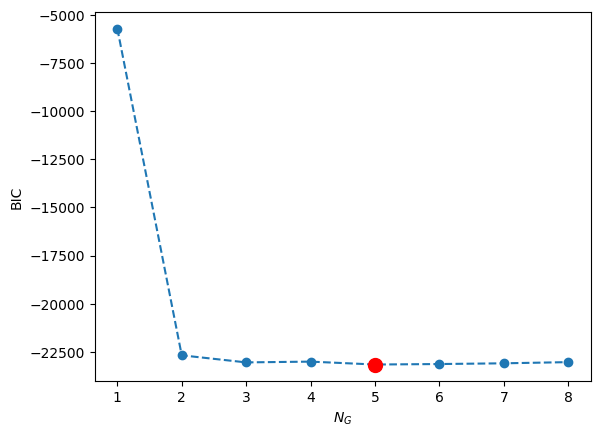

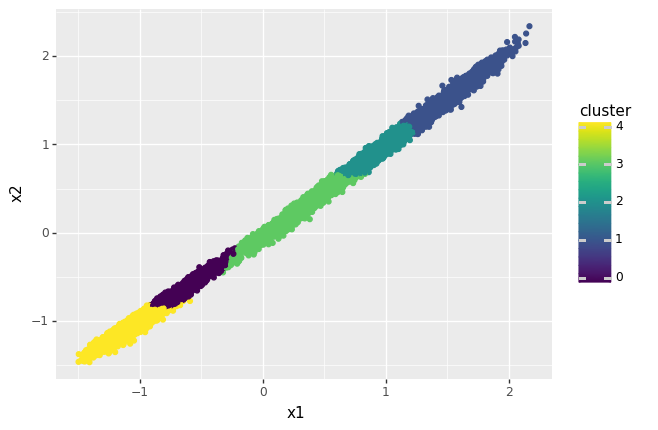

<ggplot: (8740172236915)>

In [218]:
# Standard scale the 'code'
z = StandardScaler()
X = z.fit_transform(code_np)

# Keep all the BIC scores
bics = []

# Put the scaled data into a dataframe
features = ["x1", "x2"]
X = pd.DataFrame(X, columns = features)
comp_range = range(1,9)

for n in comp_range:
  # Define the Gaussian mixture models instance
  EM = GaussianMixture(n_components = n)

  # Train the model on the data and cluster
  EM.fit(X)
  cluster = EM.predict(X)

  # Score
  bic = EM.bic(X.values)
  bics.append(bic)

n_components = np.argmin(bics) + 1

plt.plot(list(comp_range), bics, marker = 'o', linestyle = '--')
plt.plot(n_components, bics[n_components - 1], marker='o', markersize=10, color='red')
plt.xlabel('$N_G$')
plt.ylabel('BIC')
plt.show()

EM = GaussianMixture(n_components = n_components)
EM.fit(X)
cluster = EM.predict(X)
X['cluster'] = cluster

#Print the clusters
(ggplot(X, aes(x = 'x1', y = "x2", color = 'cluster'))) + geom_point()

Next step is to start considering mixture models with number of components smaller or equal than the one that leads to the lowest BIC score, by merging clusters withing the model. The number of components for our final model will be the one that leads to the lowest cross entropy.

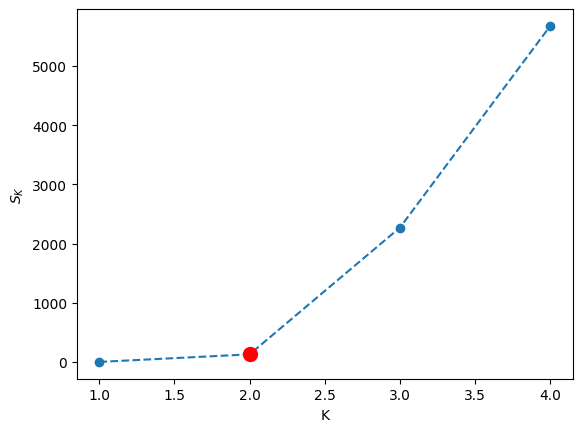

In [221]:
EM = GaussianMixture(n_components = 4)
EM.fit(code_np)
probabilities = EM.predict_proba(code_np)
og_cluster_ids = list(range(probabilities.shape[1]))
counter = 1
entropies_ = [np.sum(-probabilities * np.log(probabilities))]
while(probabilities.shape[1] > 1):

  # Define the list of integers
  cluster_ids = list(range(probabilities.shape[1]))

  # Get all combinations
  combinations_list = []
  combination_length = 2
  combinations_list.extend(list(combinations(cluster_ids, combination_length)))

  # Calculate the entropy of the clustering from the merging of components
  entropies_temp = []
  for combination in combinations_list:
    new_prob = probabilities[:,combination[0]] + probabilities[:,combination[1]]
    entropies_temp.append(np.sum(-new_prob * np.log(new_prob)))

  # Choose the pair that leads to
  argmin_entropy = np.argmin(entropies_temp)
  combination = combinations_list[argmin_entropy]

  #Merge probabilities
  if probabilities.shape[1] == 2:
    probs_2 = probabilities

  probabilities[:,combination[0]] = probabilities[:,combination[0]] + probabilities[:,combination[1]]
  probabilities = np.delete(probabilities, combination[1], axis=1)

  #Keep the entropy of the clustering for the best merging
  entropies_.append(np.sum(-probabilities * np.log(probabilities)))

# Plot the entropies with the number of clusters
entropies_ = entropies_[::-1]
plt.plot(range(1, len(og_cluster_ids) + 1),entropies_, marker = 'o', linestyle = '--')
plt.plot(2, entropies_[1], marker='o', markersize=10, color='red')
plt.xlabel('K')
plt.ylabel('$S_K$')
plt.show()

We observe that there is an elbow to the graph for number of clusters $K=2$. Therefore, we train a GMM for 2 components.

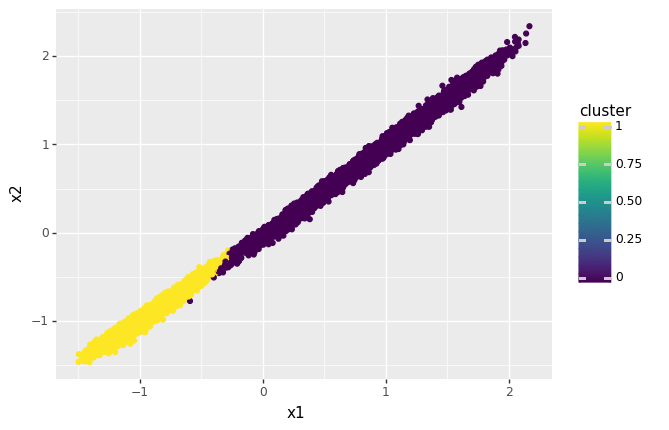

<ggplot: (8740171191032)>

In [231]:
z = StandardScaler()
X = z.fit_transform(code_np)

features = ["x1", "x2"]
X = pd.DataFrame(X, columns = features)

EM = GaussianMixture(n_components = 2)
EM.fit(code_np)
cluster = EM.predict(code_np)
probabilities = EM.predict_proba(code_np)
X['cluster'] = cluster

(ggplot(X, aes(x = 'x1', y = "x2", color = 'cluster'))) + geom_point()

Now, we plot the distribution of the averaged BOPs for each cluster and find where the distributions are relatively well separated.

In [232]:
clustered_bops = np.hstack((bops_np, cluster.reshape((-1, 1))))
clustered_bops_df = pd.DataFrame(clustered_bops, columns=[f'q{num}' for num in range(1, 9)] + ['cluster'])
bops_c0 = clustered_bops_df[clustered_bops_df.cluster == 0]
bops_c1 = clustered_bops_df[clustered_bops_df.cluster == 1]

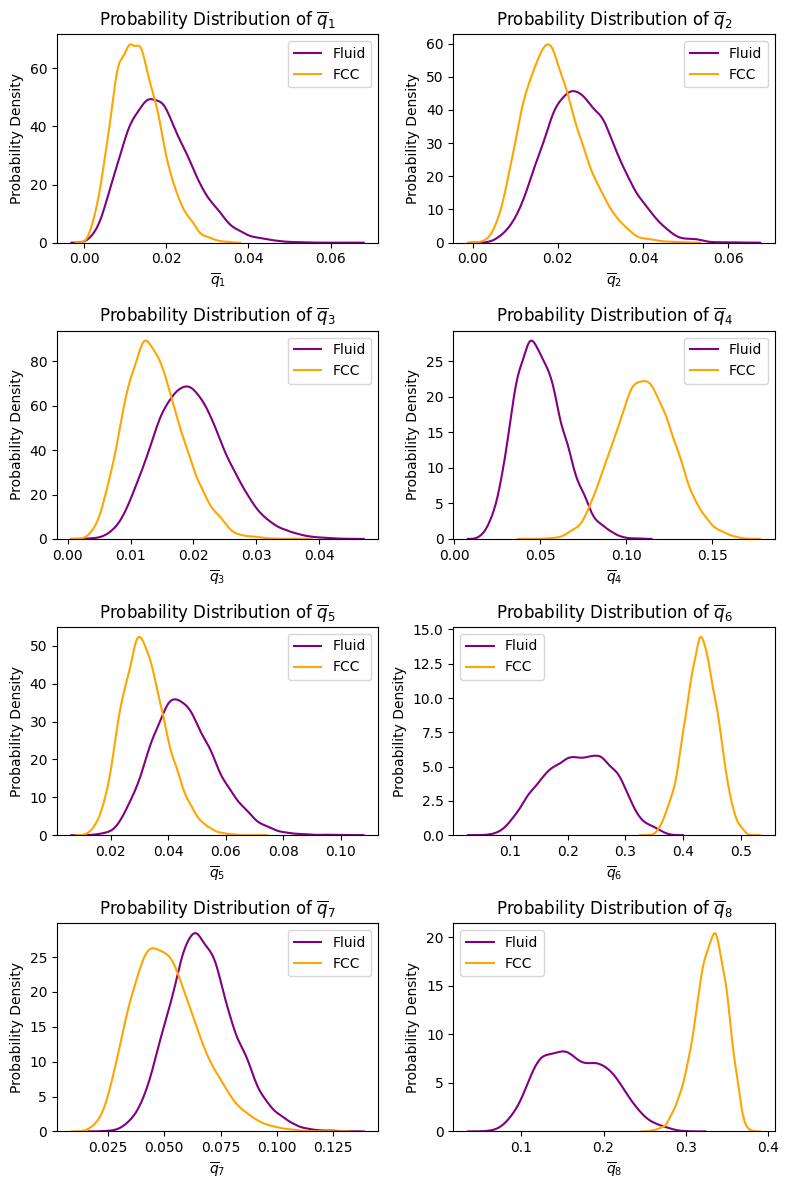

In [233]:
fig, axes = plt.subplots(4, 2, figsize=(8, 12))

for num in range(1, 9):
    axis1 = int((num - 1) / 2)  # Calculate the row index of the subplot
    axis2 = (num - 1) % 2  # Calculate the column index of the subplot

    # Plot the KDE plots on each subplot
    sns.kdeplot(data=bops_c0[f"q{num}"], color='purple', label='Fluid', ax=axes[axis1, axis2], common_norm=True)
    sns.kdeplot(data=bops_c1[f"q{num}"], color='orange', label='FCC', ax=axes[axis1, axis2], common_norm=True)

    # Add labels and title to the subplot
    axes[axis1, axis2].set_xlabel("$\overline{q}_" + f"{num}$")
    axes[axis1, axis2].set_ylabel('Probability Density')
    axes[axis1, axis2].set_title("Probability Distribution of $\overline{q}_" + f"{num}$")

    # Display the legend in the subplot
    axes[axis1, axis2].legend()

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

Lastly, we go back to the original 8-dimensional space, we cluster the points and project the data onto the planes $(\overline{q}_l-\overline{q}_k)$ for the $\overline{q}_l$ and $\overline{q}_k$ whose distributions for each cluster are relatively well separated.

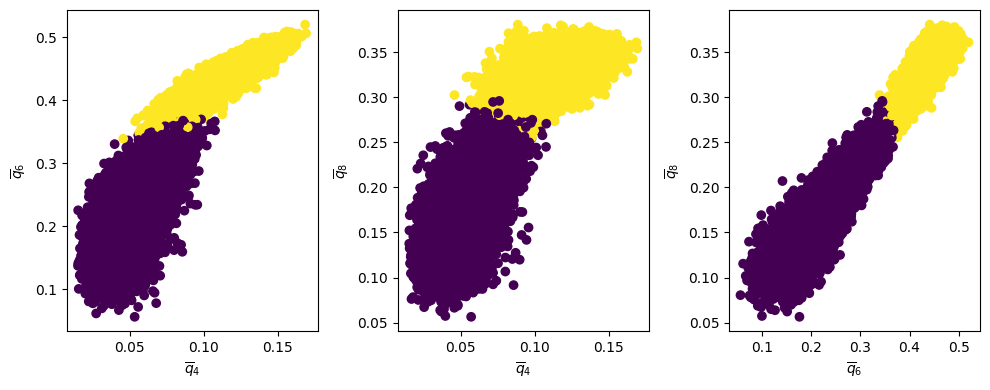

In [234]:
# Get all combinations
combinations_list = list(combinations([4,6,8], 2))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for num, (comb1, comb2) in enumerate(combinations_list):
    # axis1 = int(num / 2)  # Calculate the row index of the subplot
    # axis2 = num % 2  # Calculate the column index of the subplot

    # Plot scatterplot with color based on cluster
    axes[num].scatter(clustered_bops_df[f"q{comb1}"], clustered_bops_df[f"q{comb2}"], c=clustered_bops_df['cluster'])

    # Set x-axis and y-axis labels
    axes[num].set_xlabel("$\overline{q}_" + f"{comb1}$")
    axes[num].set_ylabel("$\overline{q}_" + f"{comb2}$")

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()